In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
# Network
# Credit of this code block goes to Gropp, Amos and Yariv, Lior and Haim, Niv and Atzmon, Matan and Lipman, Yaron
# Link to the original code: https://github.com/amosgropp/IGR
class Implicit(torch.nn.Module):
  def __init__(self, dimension):
    super().__init__()

    dims = [ 512, 512, 512, 512, 512, 512, 512, 512 ]     # Size of each layer
    beta = 100
    skip_in = [4]                                         # Skip connection
    radius_init = 1

    dims = [dimension] + dims + [1]

    self.num_layers = len(dims)
    self.skip_in = skip_in

    for layer in range(0, self.num_layers - 1):
      if layer + 1 in skip_in:
        out_dim = dims[layer + 1] - dimension
      else:
        out_dim = dims[layer + 1]

      lin = torch.nn.Linear(dims[layer], out_dim)

      if layer == self.num_layers - 2:
        torch.nn.init.normal_(lin.weight, mean=np.sqrt(np.pi) / np.sqrt(dims[layer]), std=0.00001)
        torch.nn.init.constant_(lin.bias, -radius_init)
      else:
        torch.nn.init.constant_(lin.bias, 0.0)
        torch.nn.init.normal_(lin.weight, 0.0, np.sqrt(2) / np.sqrt(out_dim))

      setattr(self, "lin" + str(layer), lin)

    self.activation = torch.nn.Softplus(beta=beta)

  def forward(self, inputs):
    x = inputs

    for layer in range(0, self.num_layers - 1):
      lin = getattr(self, "lin" + str(layer))

      if layer in self.skip_in:
        x = torch.cat([x, inputs], -1) / np.sqrt(2)

      x = lin(x)

      if layer < self.num_layers - 2:
        x = self.activation(x)

    return x

In [3]:
#Setting up
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')   # Check if the device is CPU or GPU

model = Implicit(dimension=1).train().to(device)                        # Innitialize the neural network
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)             # Innitialize the optimizer

data = torch.tensor([[0.], [1.]]).to(device)                            # Input point-cloud
data.requires_grad = True
distribution = torch.arange(-0.2, 1.2, 0.1).unsqueeze(1).to(device)     # Distribution
distribution.requires_grad = True

num_of_epochs = 5000

geo_coeff = 10.                                                         # Innitialize weights
constraint_coeff = 1.
off_coeff = 0.5

p = 8                                                                   # p value for p-Laplacian

In [4]:
#Training
for i in range(num_of_epochs):
  model.train()
  optimizer.zero_grad()

  f_data = model(data)            # Function values at points in the point-cloud
  f_dist = model(distribution)    # Function values at points in the distribution

  # Geometric loss
  geo_loss = f_data.abs().mean()

  # p-Laplacian constraint
  # Compute the gradient
  g = torch.autograd.grad(outputs=f_dist,
                          inputs=distribution,
                          grad_outputs=torch.ones_like(f_dist, requires_grad=False, device=f_dist.device), 
                          create_graph=True,
                          retain_graph=True, 
                          only_inputs=True)[0][:, -3:]
  # Compute the p-Laplacian
  g = ((g.norm(2, dim=-1).view(g.shape[0],1))**(p-2))  * g
  div = 0.
  for i in range(g.shape[-1]):
    div += torch.autograd.grad(g[..., i], distribution, grad_outputs=torch.ones_like(g[..., i]), create_graph=True)[0][..., i:i+1]
    
  constraint = ((div - 1)**2).mean()

  # Off-surface constriant
  off_constraint = torch.exp(-100 * f_dist.abs()).mean()

  loss = geo_coeff * geo_loss + constraint_coeff * constraint + off_coeff * off_constraint

  loss.backward()
  optimizer.step()
  optimizer.zero_grad()

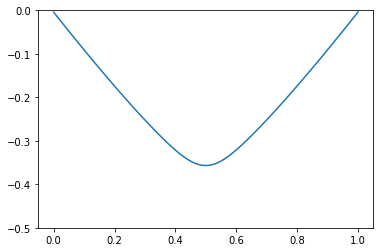

In [5]:
# Plot
grid = torch.arange(0, 1.01, 0.01).unsqueeze(1).to(device)
z_model = model(grid)

plt.plot(grid.detach().cpu().numpy(), z_model.detach().cpu().numpy())
plt.ylim(-0.5,0)
plt.show()